# Picking branch effects apart to make a model

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint
from progressbar import ProgressBar
import lifelines

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp, token_eq
from analysis.transformations import gaps
from analysis import settings

config = GistsConfiguration.get_solo()
nlp = get_nlp()

## 2 Setup

We need a few helper functions first

In [4]:
def gapless(sequence, idx):
    if token_eq(sequence[idx], settings.ALIGNMENT_GAP_CHAR):
        raise ValueError("index {} is a gap in sequence {}"
                         .format(idx, sequence))
    return idx - int(np.sum([token_eq(el, settings.ALIGNMENT_GAP_CHAR)
                             for el in sequence[:idx]]))

def set_order_array(ids):
    return np.array(list(sorted(set(ids))), dtype=int)


def chunk_indices_with_children_exc(deep_alignments):
    for dal in deep_alignments:
        seq1 = dal['seq1']
        seq2 = dal['seq2']
        subalignments = dal['subalignments']
        
        # Compute this level's app/dis/apprpl/disrpl/stb ids
        base_app_ids = []
        base_dis_ids = []
        base_rpl_pairs = []
        base_stb_pairs = []
        for i, (tok1, tok2) in enumerate(zip(seq1, seq2)):
            if token_eq(tok1, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok2, settings.ALIGNMENT_GAP_CHAR)
                base_app_ids.append(gapless(seq2, i))
            elif token_eq(tok2, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok1, settings.ALIGNMENT_GAP_CHAR)
                base_dis_ids.append(gapless(seq1, i))
            elif tok1.lemma == tok2.lemma or tok1.orth == tok2.orth:
                base_stb_pairs.append((gapless(seq1, i), gapless(seq2, i), False))
            else:
                base_rpl_pairs.append((gapless(seq1, i), gapless(seq2, i), False))

        # Check we saw all the parent ids exactly once
        parent_ids = (base_dis_ids +
                      [pid for pid, _, _ in base_rpl_pairs] +
                      [pid for pid, _, _ in base_stb_pairs])
        assert len(set(parent_ids)) == max(parent_ids) + 1
        
        # See if that's all the work we have to do
        if len(subalignments) == 0:
            yield (set_order_array(base_app_ids),
                   set_order_array(base_dis_ids),
                   set_order_array(base_rpl_pairs),
                   set_order_array(base_stb_pairs))
            # Don't recurse more since there are no subalignments.
            # Instead move on to the next deep_alignment.
            break
        
        # Nope, we must combine this level with all the combinations of subalignments
        for subalignment in subalignments:
            
            if len(subalignment) == 0:
                # This subalignment is the base alignment (which was as good as
                # or better than other subalignments)
                yield (set_order_array(base_app_ids),
                       set_order_array(base_dis_ids),
                       set_order_array(base_rpl_pairs),
                       set_order_array(base_stb_pairs))
                continue
            
            # For this mapping, get the list of exchanges and the list of chunk_indices iterators
            # from each exchange
            excs, excs_chunk_indices_iter = zip(*[(exc, chunk_indices_with_children_exc(exc_dals))
                                                  for exc, exc_dals in subalignment.items()])
            # Loop through the product of paths from each exchange
            for excs_chunk_indices_tuple in itertools.product(*excs_chunk_indices_iter):
                app_ids = set(base_app_ids)
                dis_ids = set(base_dis_ids)
                rpl_pairs = set(base_rpl_pairs)
                stb_pairs = set(base_stb_pairs)
                
                for (((start1, stop1), (start2, stop2)),
                     (exc_app_ids, exc_dis_ids, exc_rpl_pairs, exc_stb_pairs)) \
                        in zip(excs, excs_chunk_indices_tuple):
                
                    gapless2_start1 = gapless(seq2, start1)
                    gapless2_stop1 = gapless(seq2, stop1 - 1) + 1
                    gapless1_start2 = gapless(seq1, start2)
                    gapless1_stop2 = gapless(seq1, stop2 - 1) + 1
                    
                    app_ids.difference_update(range(gapless2_start1, gapless2_stop1))
                    dis_ids.difference_update(range(gapless1_start2, gapless1_stop2))
                    
                    app_ids.update(gapless2_start1 + exc_app_ids)
                    dis_ids.update(gapless1_start2 + exc_dis_ids)
                    rpl_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid, True)
                                      for pid, cid, _ in exc_rpl_pairs])
                    stb_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid, True)
                                      for pid, cid, _ in exc_stb_pairs])
                
                yield (set_order_array(app_ids),
                       set_order_array(dis_ids),
                       set_order_array(rpl_pairs),
                       set_order_array(stb_pairs))

def contiguous_chunks(ids):
    """Get the list of contiguous chunks in `ids`.
    
    A contiguous chunk here is a suite of ids that follow each other.
    If `ids` is empty, returns an empty list.
    
    """
    
    assert len(set(ids)) == len(ids)
    ids = sorted(ids)
    if len(ids) == 0:
        return []
    
    chunks = []
    chunk = [ids[0]]
    
    for id in ids[1:]:
        if id == max(chunk) + 1:
            chunk.append(id)
        else:
            chunks.append(chunk)
            chunk = [id]
    
    chunks.append(chunk)
    return chunks

In [5]:
def branch_sentences(sentence, with_root=False, with_leaf=True):
    # Walk back up to the head of the branch
    head = sentence.head
    
    if with_root:
        yield head.parent
    
    current = head
    while current.children.kept.count() > 0 and current.depth < config.target_branch_depth:
        if current.children.kept.count() > 1:
            raise ValueError("More than one (kept) children for sentence {}"
                             .format(current.id))
        yield current
        current = current.children.kept.first()
    
    if with_leaf:
        # Yield the final leaf
        yield current

In [6]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [7]:
def plot_int_dist(x, scale=None, ax=None,
                  plot_kws={'marker': 'o', 'lw': 0}, hist_kws={},
                  **kws):
    assert scale in [None, 'ylog', 'loglog'], scale
    
    bins = np.linspace(x.min() -.5, x.max() + .5, int(x.max() - x.min() + 2))
    middles = (bins[1:] + bins[:-1]) / 2
    hist, _ = np.histogram(x, bins=bins, **hist_kws)
    
    if ax is None:
        ax = plt.gca()
    ax.plot(middles, hist, **plot_kws, **kws)
    if scale == 'ylog':
        ax.set_yscale('log')
    if scale == 'loglog':
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.locator_params(subs='all')
    return ax

Now build the master DataFrame that we plot below

In [8]:
data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            rpl_outexc = [pair for pair in rpl_pairs if not pair[2]]
            rpl_inexc = [pair for pair in rpl_pairs if pair[2]]
            stb_outexc = [pair for pair in stb_pairs if not pair[2]]
            stb_inexc = [pair for pair in stb_pairs if pair[2]]
            
            data.append({
                'tree_id': tree.id,
                'branch_id': head.id,
                'parent_id': parent.id,
                'child_id': child.id,

                'parent_depth': parent.depth,
                'parent_length': len(parent.tokens),

                'ins_count': len(app_ids),
                'del_count': len(dis_ids),
                'stb_outexc_count': len(stb_outexc),
                'rpl_outexc_count': len(rpl_outexc),
                'stb_inexc_count': len(stb_inexc),
                'rpl_inexc_count': len(rpl_inexc),
                
                'ins_chunk_count': len(contiguous_chunks(app_ids)),
                'del_chunk_count': len(contiguous_chunks(dis_ids)),
                'exc_chunk_count': len(contiguous_chunks(
                    [p[0] for p in itertools.chain(stb_inexc, rpl_inexc)])),
                'stbrpl_outexc_chunk_count': len(contiguous_chunks(
                    [p[0] for p in itertools.chain(stb_outexc, rpl_outexc)])),
                'stb_outexc_chunk_count': len(contiguous_chunks([p[0] for p in stb_outexc])),
                'rpl_outexc_chunk_count': len(contiguous_chunks([p[0] for p in rpl_outexc])),
                'stb_inexc_chunk_count': len(contiguous_chunks([p[0] for p in stb_inexc])),
                'rpl_inexc_chunk_count': len(contiguous_chunks([p[0] for p in rpl_inexc])),
            })

data = pd.DataFrame(data)

100% (50 of 50) |#########################| Elapsed Time: 0:03:35 Time: 0:03:35


## 3 Counts

Prepare some data values

In [9]:
data['exc_count'] = data.stb_inexc_count + data.rpl_inexc_count
data['stbrpl_outexc_count'] = data.stb_outexc_count + data.rpl_outexc_count
data['stb_outexc_count_rel'] = data.stb_outexc_count / data.parent_length
data['del_count_rel'] = data.del_count / data.parent_length

has_transformation = ((data.del_count > 0)
                      | (data.ins_count > 0)
                      | (data.rpl_outexc_count > 0)
                      | (data.exc_count > 0))
unique_transformation = (has_transformation
                         & (((data.del_count == 0) & (data.ins_count == 0) & (data.rpl_outexc_count == 0))
                            | ((data.del_count == 0) & (data.ins_count == 0) & (data.exc_count == 0))
                            | ((data.del_count == 0) & (data.rpl_outexc_count == 0) & (data.exc_count == 0))
                            | ((data.ins_count == 0) & (data.rpl_outexc_count == 0) & (data.exc_count == 0))))

data['has_del'] = data.del_count > 0
data['has_ins'] = data.ins_count > 0
data['has_rpl_outexc'] = data.rpl_outexc_count > 0
data['has_exc'] = data.exc_count > 0

columns_count = ['del_count',
                 'ins_count',
                 'rpl_outexc_count',
                 'exc_count',
                 'stb_outexc_count']
columns_count_rel = ['del_count_rel',
                     'stb_outexc_count_rel']
columns_chunk = ['del_chunk_count',
                 'ins_chunk_count',
                 'rpl_outexc_chunk_count',
                 'exc_chunk_count',
                 'stb_outexc_chunk_count']
max_count = data[columns_count].max().max()
max_count_rel = data[columns_count_rel].max().max()
max_chunk = data[columns_chunk].max().max()

We're going to ignore replacements inside exchanges, so that our ontology of possible transformations is: deletion, insertion, replacement, exchange (with or without inner replacement, which we ignore), stability.

Just to make sure, the total number of *transformations with replacements inside an exchange* is:

In [10]:
(data.rpl_inexc_count > 0).sum()

36

Totalling this many words replaced:

In [11]:
data.rpl_inexc_count.sum()

44

vs. the number of transformations with replacements out of an exchange:

In [12]:
(data.rpl_outexc_count > 0).sum()

1324

### Counts

Contingency table for deletion and insertion only:

In [13]:
data['del_count']\
    .groupby([(data.del_count > 0), (data.ins_count > 0)])\
    .count()\
    .rename_axis(['Deletion', 'Insertion'])\
    .unstack(0)


Deletion,False,True
Insertion,,
False,1796,593
True,160,912


Without deletion, insertion has very low probability. With insertion, deletion has very high probability. One way to see this is to look at deletions first, and then look at the distribution of insertions. Below we compare the distribution of insertions without and with deletion:

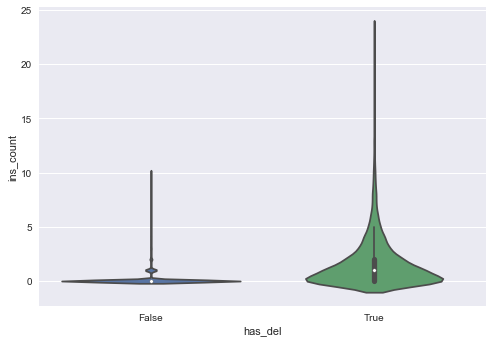

In [14]:
sb.violinplot(y='ins_count', x='has_del', scale='count', data=data, split=True)

Same data with a letter-value plot:

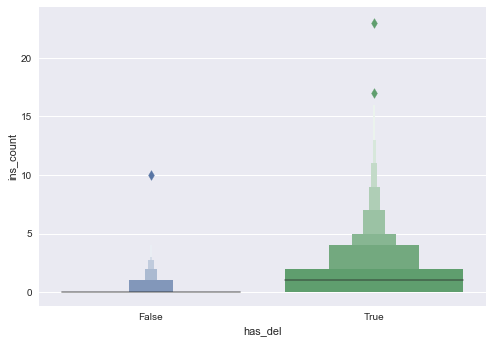

In [15]:
sb.lvplot(y='ins_count', x='has_del', data=data)

Contingency table for all our transformations:

In [16]:
data['del_count']\
    .groupby([(data.del_count > 0), (data.ins_count > 0), (data.rpl_outexc_count > 0), (data.exc_count > 0)])\
    .count()\
    .rename_axis(['Deletion', 'Insertion', 'Replacement', 'Exchange'])\
    .unstack([0, 2])


Deletion           False       True       
Replacement        False True  False True 
Insertion Exchange                        
False     False     1366   400   265   284
          True        14    16    22    22
True      False       62    87   346   431
          True         5     6    57    78

## 4 Distributions of counts for each transformation

Now a look at the distributions of counts of each transformation:

In [17]:
def plot_columns(data, columns, filtering=None, **kwargs):
    if filtering is None:
        filtering = lambda df, c: np.ones_like(df.index, dtype=bool)
    fig, axes = plt.subplots(len(columns), 1, figsize=(8, 3*len(columns)), sharex=True)
    for col, ax in zip(columns, axes):
        plot_int_dist(data[filtering(data, col)][col], ax=ax, **kwargs)
        ax.set_title(col)

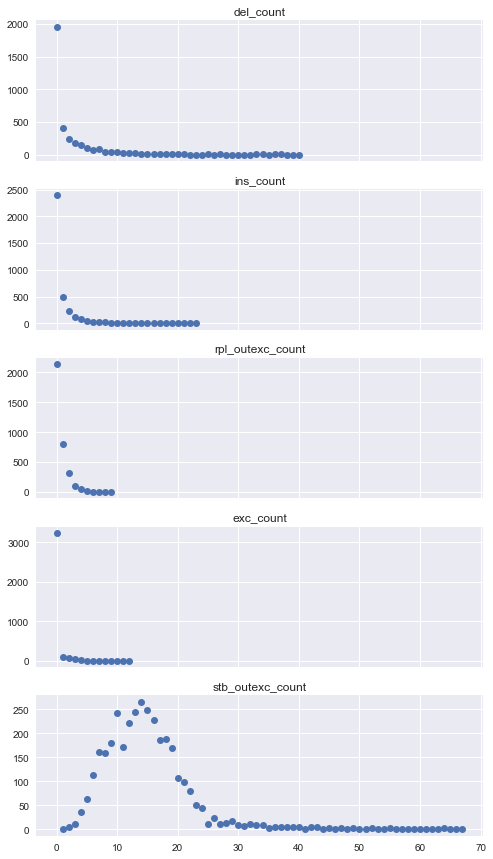

In [18]:
plot_columns(data, columns_count)

Relative to parent length, for deletions and stabilities

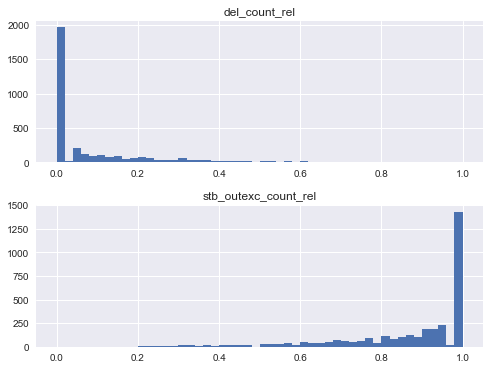

In [19]:
data[columns_count_rel].hist(bins=np.linspace(0, max_count_rel, 51),
                             layout=(len(columns_count_rel), 1),
                             figsize=(8, 3*len(columns_count_rel)));

It's pretty spiky. So taking out the spikes (keeping only non-zero counts, and taking out 0 and 1 for relative counts):

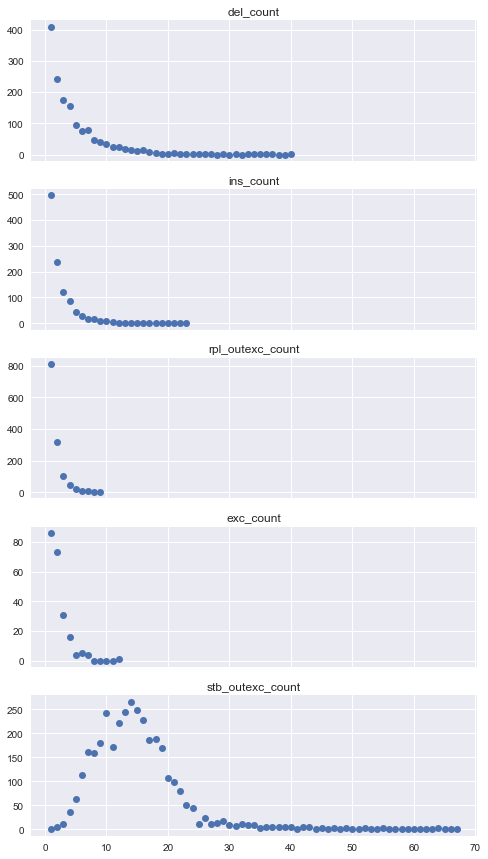

In [20]:
plot_columns(data, columns_count, filtering=lambda df, col: df[col] > 0)

Relative to parent length, for deletions and stabilities

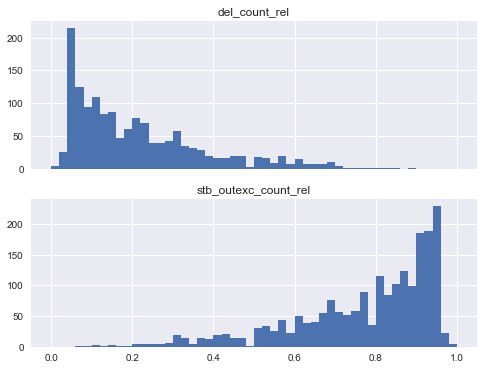

In [21]:
fig, axes = plt.subplots(len(columns_count_rel), 1,
                         figsize=(8, 3*len(columns_count_rel)), sharex=True)
for col, ax in zip(columns_count_rel, axes):
    ax.hist(data[(data[col] > 0) & (data[col] < 1)][col], bins=np.linspace(0, max_count_rel, 51))
    ax.set_title(col)

Without the non-zero restriction, but with log scale for y:

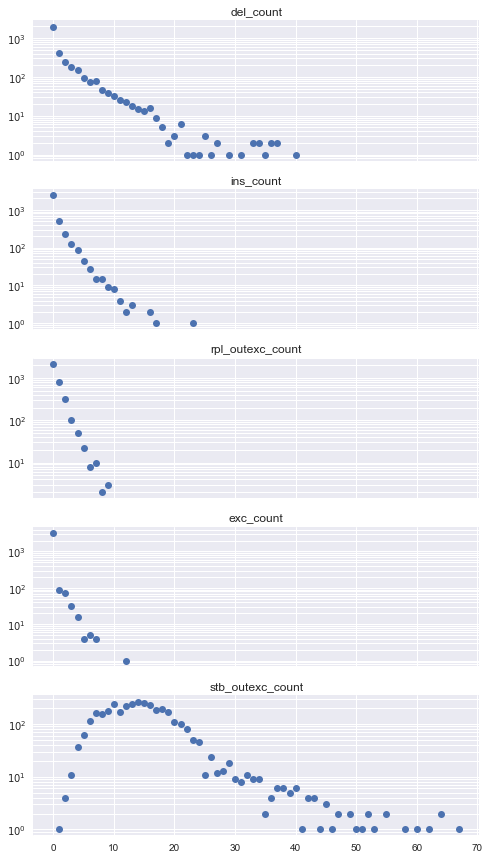

In [22]:
plot_columns(data, columns_count, scale='ylog')

Relative to parent length, for deletions and stabilities

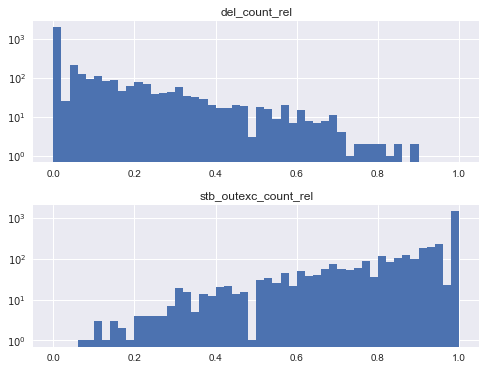

In [23]:
data[columns_count_rel].hist(bins=np.linspace(0, max_count_rel, 51),
                             layout=(len(columns_count_rel), 1),
                             figsize=(8, 3*len(columns_count_rel)), log=True);

And finally log-log:

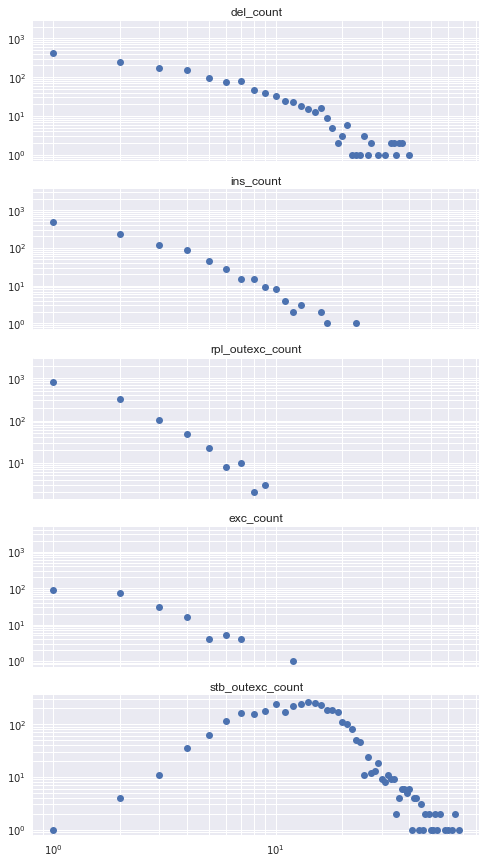

In [24]:
plot_columns(data, columns_count, scale='loglog')

Relative to parent length, for deletions and stabilities

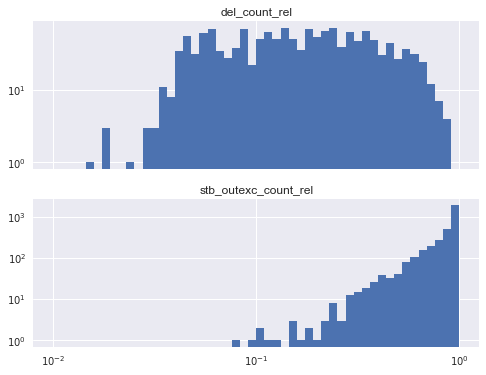

In [25]:
fig, axes = plt.subplots(len(columns_count_rel), 1,
                         figsize=(8, 3*len(columns_count_rel)), sharex=True)
for col, ax in zip(columns_count_rel, axes):
    ax.hist(data[data[col] > 0][col], bins=10**np.linspace(-2, 0, 51),
            log=True)
    ax.set_xscale('log')
    ax.set_title(col)

## 5 Correlations of counts

The number of deletions depends a lot on the size of the sentence, see the regression:

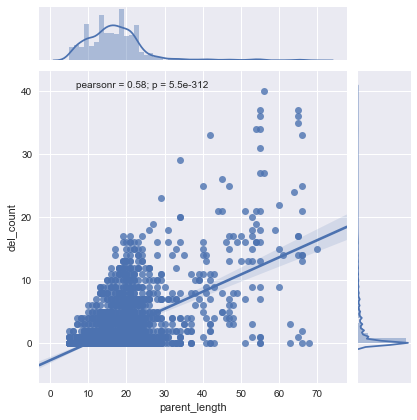

In [26]:
sb.jointplot(x='parent_length', y='del_count', data=data, kind='reg')

And residuals of the regression:

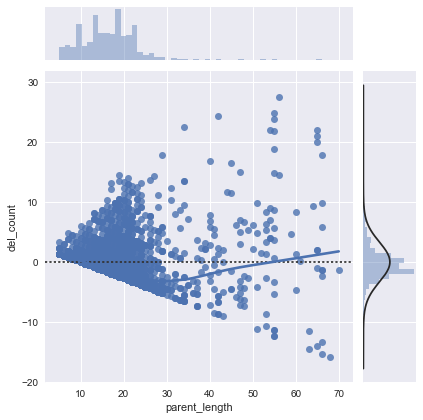

In [27]:
sb.jointplot(x='parent_length', y='del_count', data=data, kind='resid', lowess=True)

The number of insertions also relates to the number of deletions. See the regression with non-zero deletion:

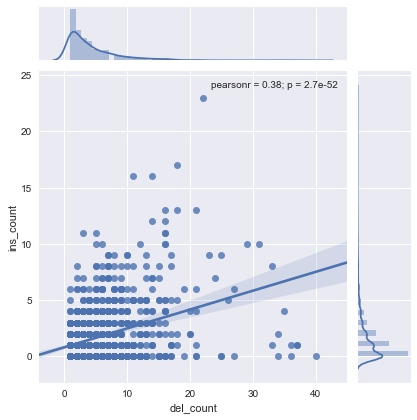

In [28]:
sb.jointplot(x='del_count', y='ins_count', data=data[(data.del_count > 0)], kind='reg')

And the regression with both non-zero deletion and non-zero insertion:

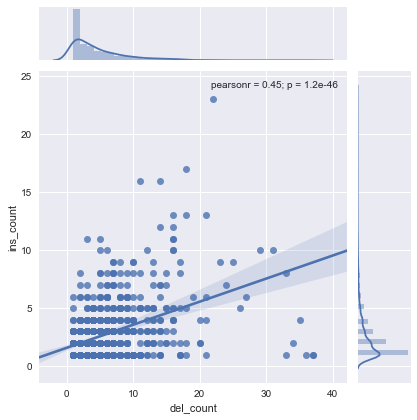

In [29]:
sb.jointplot(x='del_count', y='ins_count', data=data[(data.ins_count > 0) & (data.del_count > 0)], kind='reg')

## 6 Increase/decrease in sentence size

It looks like when there are more insertions than deletions (i.e. the length of the sentence increases), a shortening happens quickly after that. Here we try to test that.

In [30]:
increase = (data.ins_count > data.del_count)
follow_increase = pd.Series(index=data.index, data=False)
for branch_id, depth in zip(data[increase].branch_id, data[increase].parent_depth):
    follow_increase = follow_increase | ((data.branch_id == branch_id) & (data.parent_depth == depth+1))

In [31]:
data['increase'] = increase
data['follow_increase'] = follow_increase

Here's the distribution of deletions right after an increase in length, vs. not:

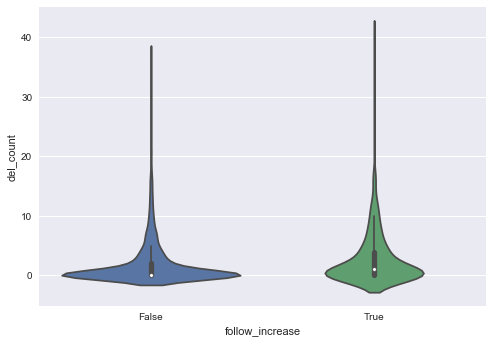

In [32]:
sb.violinplot(x='follow_increase', y='del_count', data=data)

And here's the regression of the size of length increase vs. the size of the deletion that follows it:

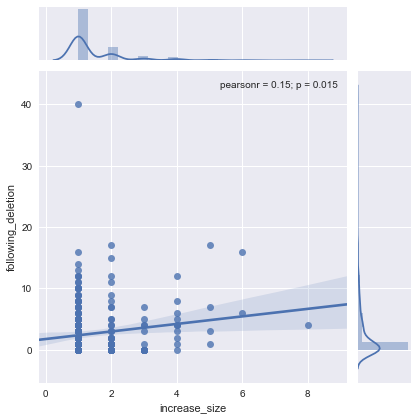

In [33]:
increase_pairs = []
for i, (branch_id, depth) in enumerate(zip(data[follow_increase].branch_id,
                                           data[follow_increase].parent_depth)):
    increase_pairs.append({
        'increase_size': (data[(data.branch_id == branch_id)
                               & (data.parent_depth == depth-1)].ins_count.iloc[0]
                          - data[(data.branch_id == branch_id)
                                 & (data.parent_depth == depth-1)].del_count.iloc[0]),
        'following_deletion': data[(data.branch_id == branch_id)
                                   & (data.parent_depth == depth)].del_count.iloc[0]
    })
increase_pairs = pd.DataFrame(increase_pairs)
sb.jointplot(x='increase_size', y='following_deletion', data=increase_pairs, kind='reg')

Not a strong correlation.

## 7 Inter-transformation interval

Prepare the data

In [34]:
stabilities = []
for branch_id in set(data.branch_id):
    child_depths = 1 + data[(data.branch_id == branch_id)
                            & (data.ins_count == 0)
                            & (data.del_count == 0)
                            & (data.exc_count == 0)
                            & (data.rpl_outexc_count == 0)].parent_depth
    for contiguous_stability in contiguous_chunks(child_depths):
        stabilities.append({
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': len(contiguous_stability),
            # Only account for unobserved end of stabilities due to branch cutoff, not spam
            'observed': max(contiguous_stability) < config.target_branch_depth
        })

stabilities = pd.DataFrame(stabilities)

Distribution of inter-transformation intervals:

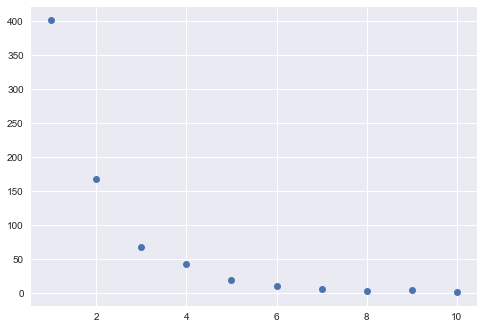

In [35]:
plot_int_dist(stabilities.duration)

And log-scaled on y:

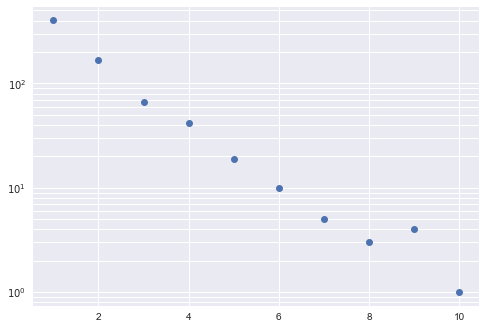

In [36]:
plot_int_dist(stabilities.duration, scale='ylog')

Note that in the plots above, there are several intervals for which we don't observe the actual end, because they reach the end of a branch. Survivial analysis is made to remedy that, and here are the corresponding plots below:

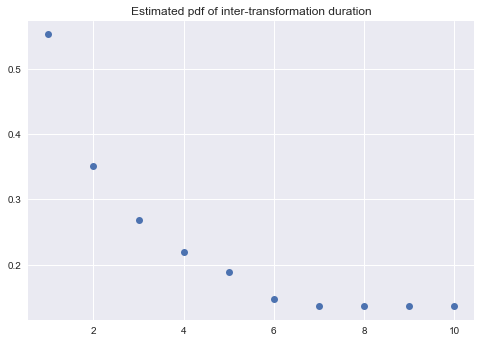

In [37]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(stabilities.duration, event_observed=stabilities.observed)

fig, ax = plt.subplots(1, 1)
ax.plot(kmf.survival_function_[1:], lw=0, marker='o')
ax.set_title('Estimated pdf of inter-transformation duration');

Log-scaled on y:

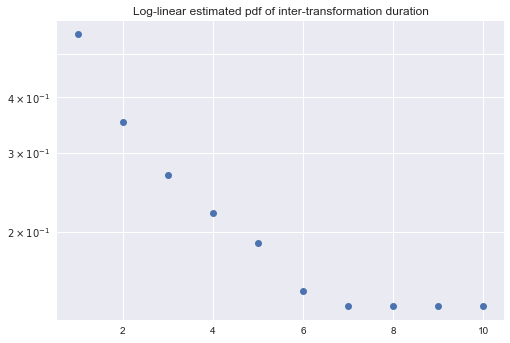

In [38]:
fig, ax = plt.subplots(1, 1)
ax.plot(kmf.survival_function_[1:], lw=0, marker='o')
ax.set_yscale('log', subsy=[])
ax.locator_params(subs='all')
ax.set_title('Log-linear estimated pdf of inter-transformation duration');

Log-log scaled:

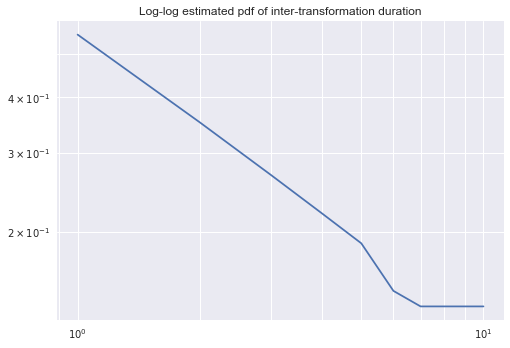

In [39]:
fig, ax = plt.subplots(1, 1)
ax.plot(kmf.survival_function_[1:])
ax.set_xscale('log', subsy=[])
ax.set_yscale('log', subsy=[])
ax.locator_params(subs='all')
ax.set_title('Log-log estimated pdf of inter-transformation duration');

So it looks like something of a power law. Trying to fit it with the 'powerlaw' package doesn't yield much, as we have so few low-frequency values.

## 8 Chunk count distribution

The number of chunks of each type found in transformations:

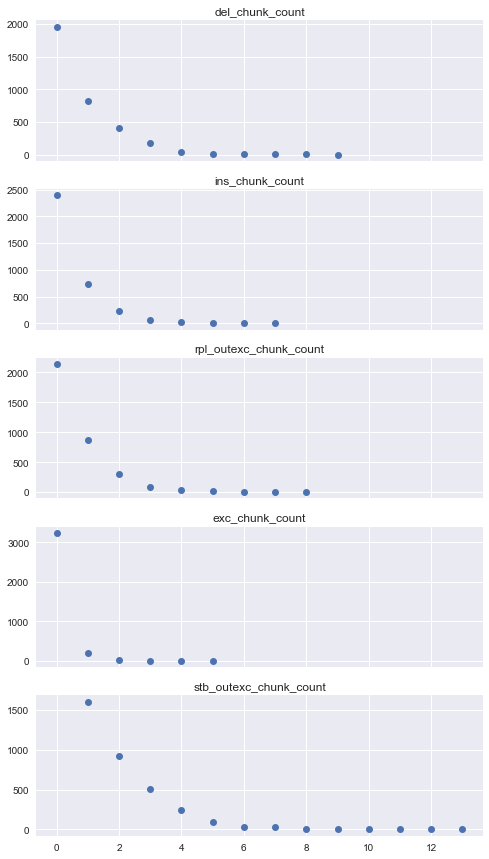

In [40]:
plot_columns(data, columns_chunk)

With a log scale on y:

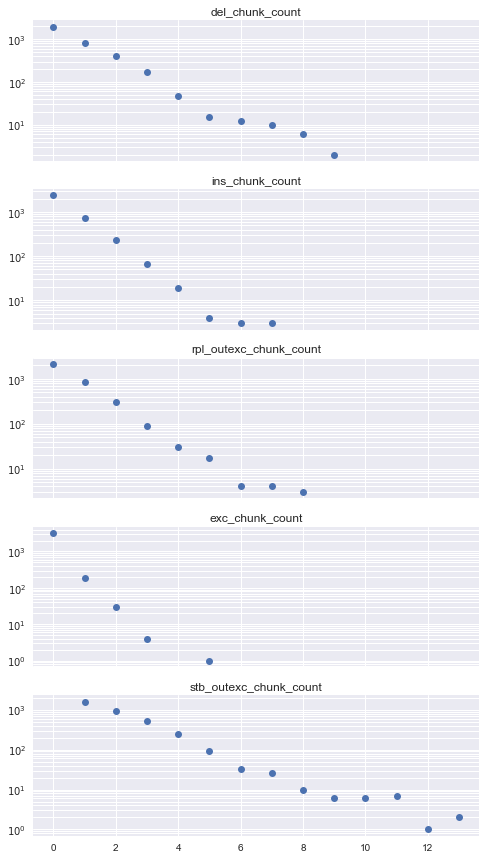

In [41]:
plot_columns(data, columns_chunk, scale='ylog')

And log-log

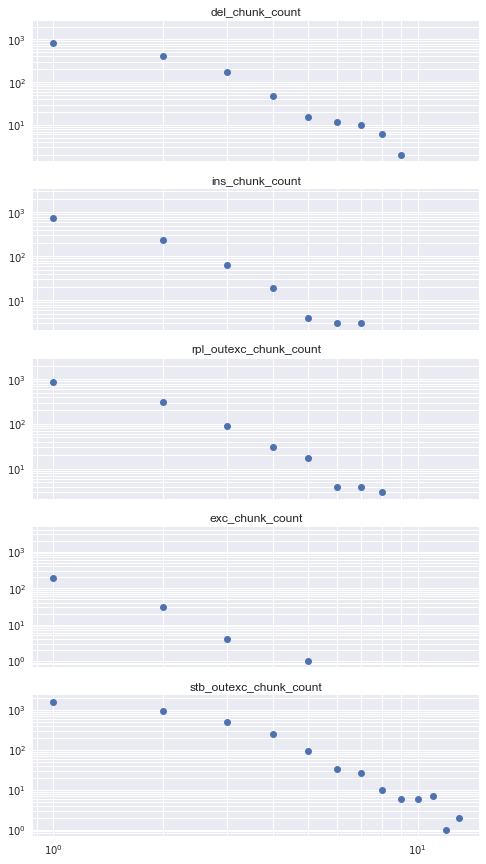

In [42]:
plot_columns(data, columns_chunk, scale='loglog')

## 9 Chunk size distribution

Prepare the data

In [43]:
data_size = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            rpl_outexc = [pair for pair in rpl_pairs if not pair[2]]
            rpl_inexc = [pair for pair in rpl_pairs if pair[2]]
            stb_outexc = [pair for pair in stb_pairs if not pair[2]]
            stb_inexc = [pair for pair in stb_pairs if pair[2]]
            
            for tipe, ref_sentence, ids in \
                [('ins', child, app_ids),
                 ('del', parent, dis_ids),
                 ('rpl', parent, [p[0] for p in rpl_outexc]),
                 ('exc', parent, [p[0] for p in itertools.chain(stb_inexc, rpl_inexc)]),
                 ('stb', parent, [p[0] for p in stb_outexc])]:
                for chunk in contiguous_chunks(ids):
                    data_size.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),

                        'tipe': tipe,
                        'chunk_size': len(chunk),
                        'chunk_start': chunk[0] / len(ref_sentence.tokens),
                        'chunk_stop': (chunk[-1] + 1) / len(ref_sentence.tokens),
                    })

columns_size = ['del', 'ins', 'rpl', 'exc', 'stb']
data_size = pd.DataFrame(data_size)

100% (50 of 50) |#########################| Elapsed Time: 0:00:25 Time: 0:00:25


The size of chunks of each type found in the transformations. Note that the size of stability chunks is exactly the size of inter-transformation intervals.

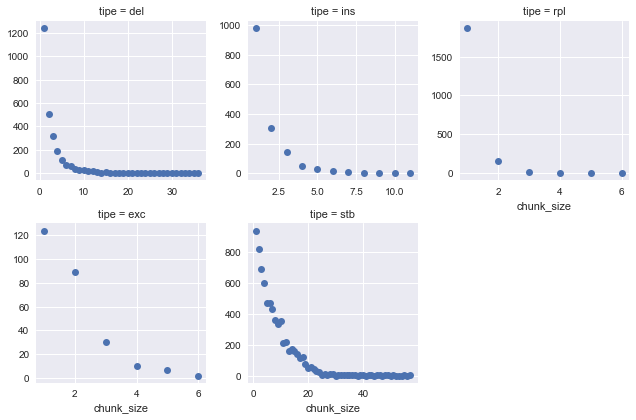

In [44]:
g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size,
                 col_wrap=3, sharex=False, sharey=False, size=3)
g.map(plot_int_dist, 'chunk_size')

With a log scale on y:

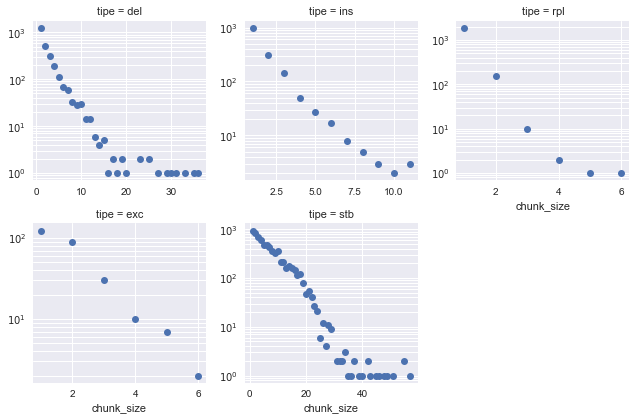

In [45]:
g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size,
                 col_wrap=3, sharex=False, sharey=False, size=3)
g.map(plot_int_dist, 'chunk_size', scale='ylog')

And finally log-log for deletion and stability:

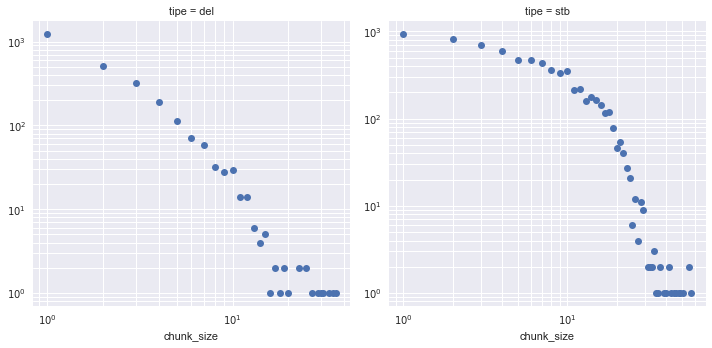

In [46]:
g = sb.FacetGrid(data_size, col='tipe', col_order=['del', 'stb'],
                 col_wrap=3, sharex=False, sharey=False, size=5)
g.map(plot_int_dist, 'chunk_size', scale='loglog')

## 10 Burstiness of it all

First a few helpers

In [47]:
def burstiness(inter_events):
    s = inter_events.std()
    m = inter_events.mean()
    return (s - m) / (s + m)

In [48]:
def intervals(ids):
    last_end = None
    for chunk in contiguous_chunks(ids):
        if last_end is not None:
            yield chunk[0] - last_end - 1
        last_end = chunk[-1]
        yield from (len(chunk) - 1) * [0]

In [49]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [50]:
def powerset_nontrivial(iterable):
    return itertools.islice(powerset(iterable), 1, None)

### 10.1 Bursts of transformations in a sentence

Prepare the data

In [51]:
data_size_intervals = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            rpl_outexc = [pair for pair in rpl_pairs if not pair[2]]
            rpl_inexc = [pair for pair in rpl_pairs if pair[2]]
            stb_outexc = [pair for pair in stb_pairs if not pair[2]]
            stb_inexc = [pair for pair in stb_pairs if pair[2]]
            
            for tipe_ids in itertools.chain(
                    powerset_nontrivial([('del', dis_ids),
                                         ('rpl_parent', [p[0] for p in rpl_outexc]),
                                         ('exc_parent', [p[0] for p in itertools.chain(stb_inexc,
                                                                                       rpl_inexc)])]),
                    powerset_nontrivial([('ins', app_ids),
                                         ('rpl_child', [p[1] for p in rpl_outexc]),
                                         ('exc_child', [p[1] for p in itertools.chain(stb_inexc,
                                                                                      rpl_inexc)])])):
                tipe, ids = zip(*tipe_ids)
                ids = list(itertools.chain(*ids))
                tipe = '+'.join(tipe)
                for interval in intervals(ids):
                    data_size_intervals.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),

                        'tipe': tipe,
                        'interval_size': interval
                    })

data_size_intervals = pd.DataFrame(data_size_intervals)

100% (50 of 50) |#########################| Elapsed Time: 0:00:25 Time: 0:00:25


Compute burstinesses for all combinations of transformations, with zero-valued intervals

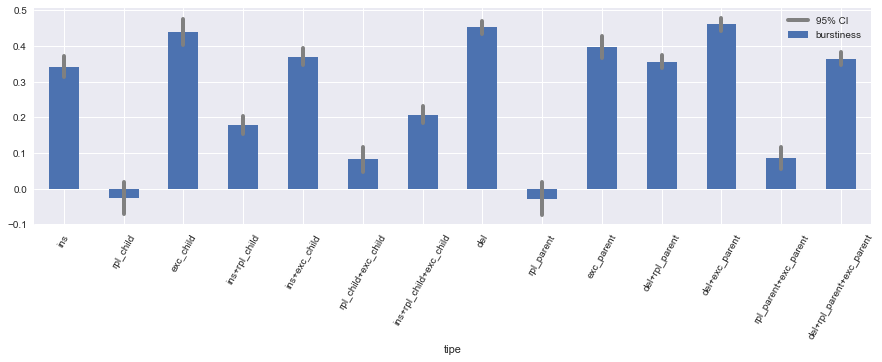

In [52]:
order = ['+'.join(t) for t in itertools.chain(powerset_nontrivial(['ins', 'rpl_child', 'exc_child']),
                                              powerset_nontrivial(['del', 'rpl_parent', 'exc_parent']))]
word_burstiness = pd.DataFrame({
    'burstiness': data_size_intervals
         .groupby(['tree_id', 'tipe'])
         .interval_size
         .aggregate(burstiness)
})

word_burstiness['ci'] = word_burstiness.burstiness
word_burstiness = word_burstiness\
    .groupby(level=1)\
    .aggregate({
        'burstiness': 'mean',
        'ci': lambda x: x.std(ddof=1) * stats.t.ppf(1 - .05/2, x.size - 1) / np.sqrt(x.size)
    }).ix[order]

ax = word_burstiness.burstiness.plot(kind='bar', figsize=(15, 4), rot=60)
for i, row in enumerate(order):
    b = word_burstiness.ix[row].burstiness
    ci = word_burstiness.ix[row].ci
    ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
            label='95% CI' if i == 0 else None)
ax.legend()

Now without zero-valued intervals, i.e. burstiness of chunks of events

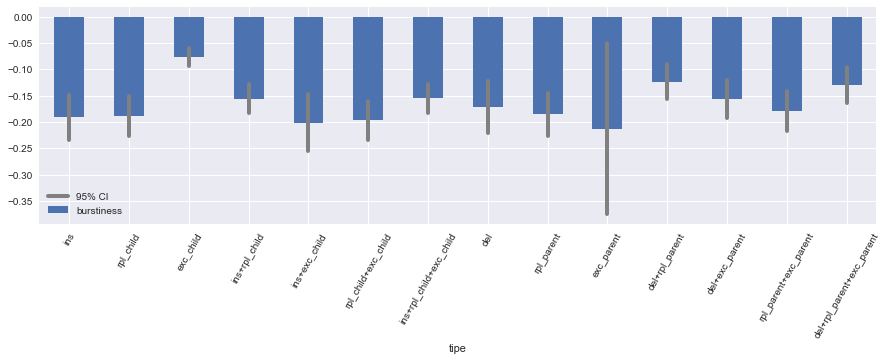

In [53]:
chunk_burstiness = pd.DataFrame({
    'burstiness': data_size_intervals[data_size_intervals.interval_size > 0]
         .groupby(['tree_id', 'tipe'])
         .interval_size
         .aggregate(burstiness)
})

chunk_burstiness['ci'] = chunk_burstiness.burstiness
chunk_burstiness = chunk_burstiness\
    .groupby(level=1)\
    .aggregate({
        'burstiness': 'mean',
        'ci': lambda x: x.std(ddof=1) * stats.t.ppf(1 - .05/2, x.size - 1) / np.sqrt(x.size)
    }).ix[order]

ax = chunk_burstiness.burstiness.plot(kind='bar', figsize=(15, 4), rot=60)
for i, row in enumerate(order):
    b = chunk_burstiness.ix[row].burstiness
    ci = chunk_burstiness.ix[row].ci
    ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
            label='95% CI' if i == 0 else None)
ax.legend()

So if you compress chunks to a single event, it's not bursty at all. Except for exchanges. But note that there are very few interval measures between chunks of exchanges:

In [54]:
len(data_size_intervals[(data_size_intervals.tipe == 'exc_parent')
                        & (data_size_intervals.interval_size > 0)])

42

So more than a burstiness, we see something of a chunkiness.

### 10.2 Bursts of sentence transformations in a branch

Prepare the data

In [55]:
stabilities0 = []
for branch_id in set(data.branch_id):
    child_depths = 1 + data[(data.branch_id == branch_id)
                            & (data.ins_count == 0)
                            & (data.del_count == 0)
                            & (data.exc_count == 0)
                            & (data.rpl_outexc_count == 0)].parent_depth
    for contiguous_stability in contiguous_chunks(child_depths):
        stabilities0.append({
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': len(contiguous_stability),
            # Only account for unobserved end of stabilities due to branch cutoff, not spam
            'observed': max(contiguous_stability) < config.target_branch_depth
        })
    for chunk in contiguous_chunks(set(1 + data[data.branch_id == branch_id].parent_depth)
                                   .difference(child_depths)):
        stabilities0.extend((len(chunk) - 1) * [{
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': 0,
            'observed': True
        }])

stabilities0 = pd.DataFrame(stabilities0)

Burstiness using all stabilities or observed-only, with or without zero-valued intervals

In [56]:
sentence_burstiness = pd.DataFrame({
    'all': stabilities0
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'observed-only': stabilities0[stabilities0.observed]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'chunk all': stabilities0[stabilities0.duration > 0]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'chunk observed-only': stabilities0[(stabilities0.duration > 0) & stabilities0.observed]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness)
})

for flavour in ['all', 'observed-only', 'chunk all', 'chunk observed-only']:
    avg = sentence_burstiness[flavour].mean()
    print("Sentence burstiness ({}) = {}".format(flavour, avg))
    ci = (sentence_burstiness[flavour].std(ddof=1)
          * stats.t.ppf(1 - .05/2, sentence_burstiness[flavour].size - 1)
          / np.sqrt(sentence_burstiness[flavour].size))
    print("CI ({}) = [{}, {}]".format(flavour, avg - ci, avg + ci))
    print()

Sentence burstiness (all) = 0.250934562713121
CI (all) = [0.2222545814744477, 0.27961454395179425]

Sentence burstiness (observed-only) = 0.3046198469476558
CI (observed-only) = [0.27349617978182633, 0.3357435141134853]

Sentence burstiness (chunk all) = -0.24721291329549802
CI (chunk all) = [-0.2859490581410662, -0.20847676844992982]

Sentence burstiness (chunk observed-only) = -0.3117747223693398
CI (chunk observed-only) = [-0.35043904791229763, -0.27311039682638194]



And note that even for that last flavour, we have quite a few measures:

In [57]:
((stabilities0.duration > 0) & stabilities0.observed).sum()

501

## 11 Position in sentence

Prepare the data

In [58]:
data_position = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            rpl_outexc = [pair for pair in rpl_pairs if not pair[2]]
            rpl_inexc = [pair for pair in rpl_pairs if pair[2]]
            stb_outexc = [pair for pair in stb_pairs if not pair[2]]
            stb_inexc = [pair for pair in stb_pairs if pair[2]]
            
            for tipe, ref_sentence, ids in \
                    [('del', parent, dis_ids),
                     ('ins', child, app_ids),
                     ('rpl_parent', parent, [p[0] for p in rpl_outexc]),
                     ('rpl_child', child, [p[1] for p in rpl_outexc]),
                     ('exc_parent', parent, [p[0] for p in itertools.chain(stb_inexc, rpl_inexc)]),
                     ('exc_child', child, [p[1] for p in itertools.chain(stb_inexc, rpl_inexc)]),
                     ('stb', parent, [p[0] for p in stb_outexc])]:
                for chunk in contiguous_chunks(ids):
                    for i, index in enumerate(chunk):
                        data_position.append({
                            'tree_id': tree.id,
                            'branch_id': head.id,
                            'parent_id': parent.id,
                            'child_id': child.id,

                            'parent_depth': parent.depth,
                            'parent_length': len(parent.tokens),
                            'child_length': len(child.tokens),

                            'tipe': tipe,
                            'is_start': i == 0,
                            'position': index,
                            'position_rel': index / (len(ref_sentence.tokens) - 1),
                            'chunk_size': len(chunk)
                        })

data_position = pd.DataFrame(data_position)
columns_position = ['del', 'ins', 'rpl_parent', 'rpl_child', 'exc_parent', 'exc_child', 'stb']

100% (50 of 50) |#########################| Elapsed Time: 0:00:25 Time: 0:00:25


Now the distributions of positions of all words in transformations

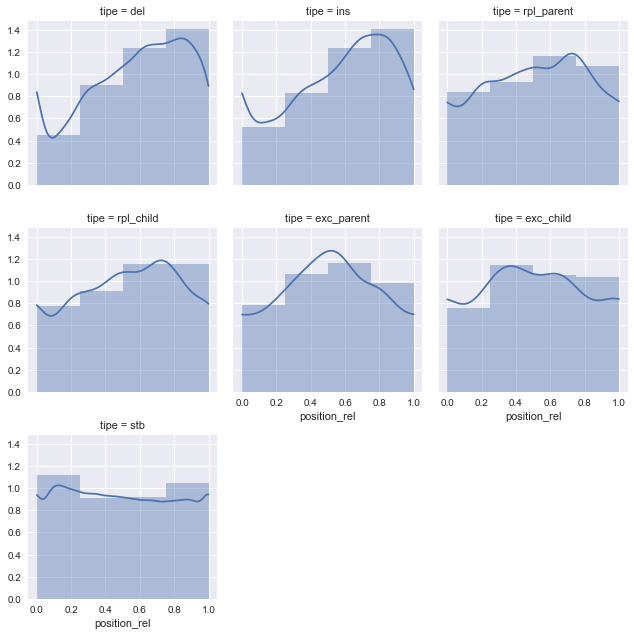

In [59]:
g = sb.FacetGrid(data=data_position,
                 col='tipe', col_wrap=3, col_order=columns_position,
                 size=3, sharex=True, sharey=True)
g.map(sb.distplot, 'position_rel', bins=4, kde_kws={'cut': 0})

Note: a more rigorous version of the plot above is done in the `chunk_word_makeup*.ipynb` notebooks, with proper weighing per sentence.

And the distributions of starts of transformations

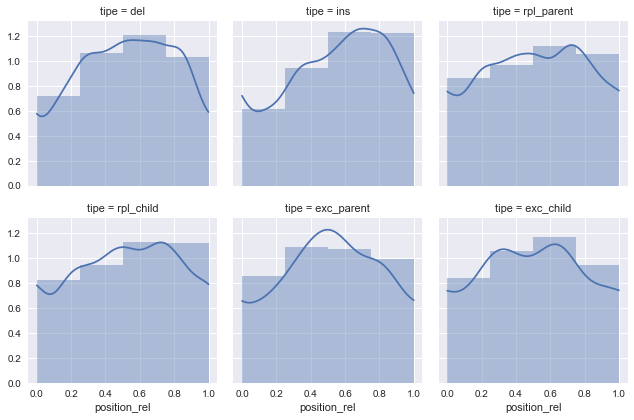

In [60]:
g = sb.FacetGrid(data=data_position[data_position.is_start],
                 col='tipe', col_wrap=3, col_order=columns_position[:-1],
                 size=3, sharex=True, sharey=True)
g.map(sb.distplot, 'position_rel', bins=4, kde_kws={'cut': 0})

In [61]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

def plot_size_positions(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    bins = kwargs.get('bins', 10)
    
    # Compute bin heights
    heights = np.zeros(bins)
    step = 1 / bins
    for i in range(bins):
        limits = [i * step, (i + 1) * step]
        weights = (bound(limits, data['chunk_stop']) - bound(limits, data['chunk_start'])) / step
        # The height of a bin is the average size of chunks which have words in it.
        # But if a chunk touches a bin only partially, it contributes only that portion
        # to the height of the bin (which is what 'weights' measures).
        heights[i] = (weights * data.chunk_size).sum() / weights.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman')
    
    # Plot them.
    x = range(1, bins + 1)
    plt.plot(x, heights, color=color)
    plt.fill_between(x, total * cis[:, 0], total * cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(x[0], x[-1])

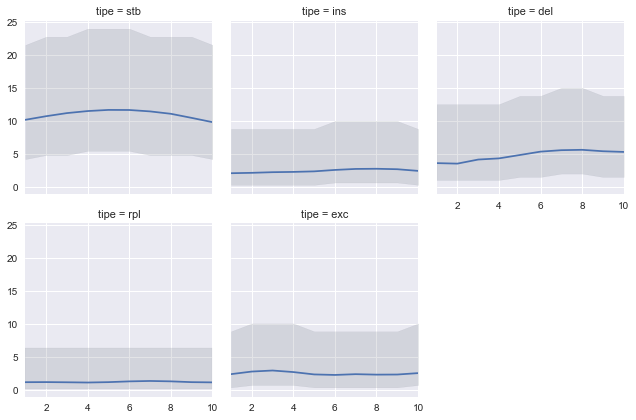

In [62]:
g = sb.FacetGrid(data=data_size, col='tipe', col_wrap=3, size=3, sharex=True, sharey=True)
g.map_dataframe(plot_size_positions)

These graphs show that the size of chunks don't vary as a function of the position in the sentence. However, the situation could look different from the point of view of the starting word of a chunk. Moslty, it does not (i.e. the size of a chunk doesn't relate to the position of the start word):

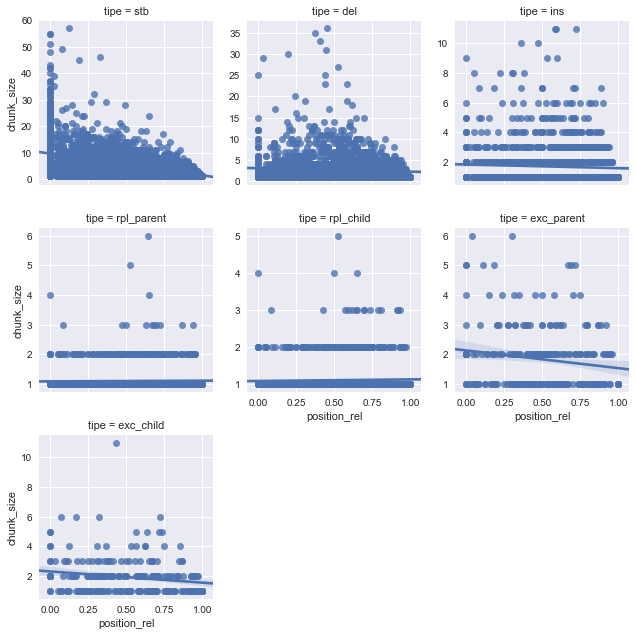

In [63]:
g = sb.FacetGrid(data=data_position[data_position.is_start],
                 col='tipe', col_wrap=3, size=3, sharex=True, sharey=False)
g.map(sb.regplot, 'position_rel', 'chunk_size')

## 12 Modelling

### 12.1 Super-simple per-word model

For each word of the parent sentence, we have the choice between deletion/insertion/replacement.

$$
p(e_n) \propto \begin{cases}
  p_d, & \text{for $e_n$ deletion} \\
  p_i, & \text{for $e_n$ insertion} \\
  p_r, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.2 Per-word + chunkiness

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* with a different probability if the preceding event is of the same type

$$
p(e_n) \propto \begin{cases}
  p_d a_d^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ deletion} \\
  p_i a_i^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ insertion} \\
  p_r a_r^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.3 Per-word + chunkiness + position-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability if the preceding event is of the same type
* and all probabilities depend on the position in the sentence

$$
p(e_n) \propto \begin{cases}
  \frac{1}{1 + e^{- a_d^{\delta_{e_{n-1}, e_n}} - \gamma_d - \beta_d n}}, & \text{for $e_n$ deletion} \\
  \frac{1}{1 + e^{- a_i^{\delta_{e_{n-1}, e_n}} - \gamma_i - \beta_i n}}, & \text{for $e_n$ insertion} \\
  \frac{1}{1 + e^{- a_r^{\delta_{e_{n-1}, e_n}} - \gamma_r - \beta_r n}}, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.4 Per-word + chunkiness + position-dependence + sentence length-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability if the preceding event is of the same type
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence

### 12.5 Per-word + event-dependent chunkiness + position-dependence + sentence length-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability depending on the type of the preceding event (i.e. compare to all event types, not only the same one)
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence

### 12.6 Per-word + event-dependent chunkiness + position-dependence + sentence length-dependence + memory

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability depending on the type of the preceding event (i.e. compare to all event types, not only the same one)
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence
* for deletion and insertion, the probability depends on the proportion of events of opposite type in a preceding window

### 12.7 Per-word-and-block

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence

### 12.8 Per-word-and-block + position-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence

### 12.9 Per-word-and-block + position-dependence + sentence-length dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence, but whose variance depends on the overall length of the sentence

### 12.10 Per-word-and-block + position-dependence + sentence-length dependence + memory

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* for deletions and insertions, it also depends on the distance to the closest opposite transformation
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence, but whose variance depends on the overall length of the sentence
* for deletions and insertions, the size of the block depends on the proportion of opposite transformations in a preceding window

## 13 Attic

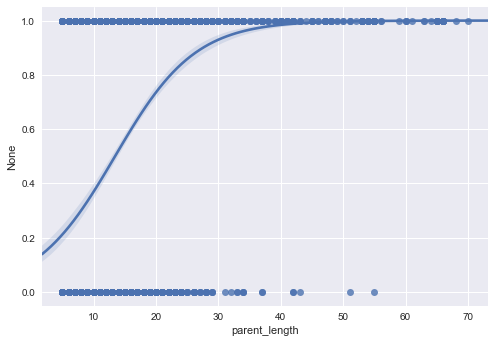

In [64]:
sb.regplot(x='parent_length', y=has_transformation, data=data, logistic=True)

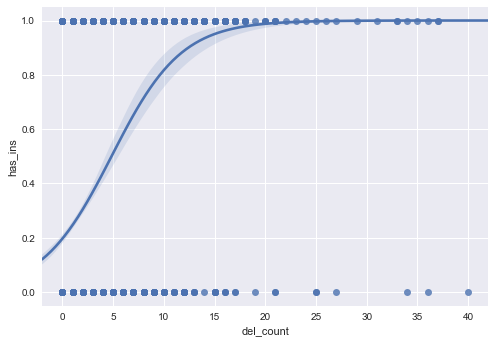

In [65]:
sb.regplot(x='del_count', y='has_ins', data=data, logistic=True)

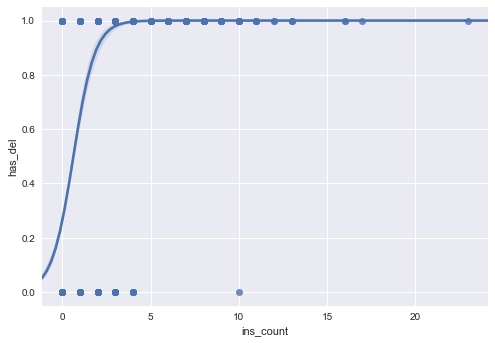

In [66]:
sb.regplot(x='ins_count', y='has_del', data=data, logistic=True)

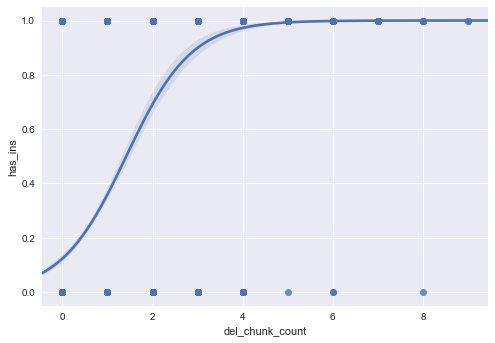

In [67]:
sb.regplot(x='del_chunk_count', y='has_ins', data=data, logistic=True)